# Sampling and Plotting

In [27]:
import sys
sys.path.append('/Training_Sampling')

import h5py
import torch
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from functools import partial
import warnings
warnings.filterwarnings("ignore")
from utility import (set_seed, get_sigmas_karras, sampler, plot_heatmaps_sample)
from Model_Designs import (marginal_prob_std, diffusion_coeff,FNO2d_Interp, FNO2d_Conv)

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device('cuda')
else:
    print("CUDA is not available.")
    device = torch.device('cpu')

CUDA is available.


## Load testing data and models

In [2]:
test_file = 'C:\\UWMadisonResearch\\SBM_FNO_Closure\\Data_Generation\\test_diffusion_nonlinear.h5'
with h5py.File(test_file, 'r') as file:
    test_diffusion_64 = torch.tensor(file['test_diffusion_64'][:], device=device)
    test_vorticity_64 = torch.tensor(file['test_vorticity_64'][:], device=device)
    test_nonlinear_64 = torch.tensor(file['test_nonlinear_64'][:], device=device)
    test_diffusion_128 = torch.tensor(file['test_diffusion_128'][:], device=device)
    test_vorticity_128 = torch.tensor(file['test_vorticity_128'][:], device=device)
    test_nonlinear_128 = torch.tensor(file['test_nonlinear_128'][:], device=device)
    test_diffusion_256 = torch.tensor(file['test_diffusion_256'][:], device=device)
    test_vorticity_256 = torch.tensor(file['test_vorticity_256'][:], device=device)
    test_nonlinear_256 = torch.tensor(file['test_nonlinear_256'][:], device=device)

    test_diffusion_64_sparse_interp = torch.tensor(file['test_diffusion_64_sparse_interp'][:], device=device)
    test_diffusion_128_sparse_interp = torch.tensor(file['test_diffusion_128_sparse_interp'][:], device=device)
    test_diffusion_256_sparse_interp = torch.tensor(file['test_diffusion_256_sparse_interp'][:], device=device)
    test_diffusion_64_sparse_normalized = torch.tensor(file['test_diffusion_64_sparse_normalized'][:], device=device)
    test_diffusion_128_sparse_normalized = torch.tensor(file['test_diffusion_128_sparse_normalized'][:], device=device)
    test_diffusion_256_sparse_normalized = torch.tensor(file['test_diffusion_256_sparse_normalized'][:], device=device)

    test_nonlinear_64_sparse_interp = torch.tensor(file['test_nonlinear_64_sparse_interp'][:], device=device)
    test_nonlinear_128_sparse_interp = torch.tensor(file['test_nonlinear_128_sparse_interp'][:], device=device)
    test_nonlinear_256_sparse_interp = torch.tensor(file['test_nonlinear_256_sparse_interp'][:], device=device)
    test_nonlinear_64_sparse_normalized = torch.tensor(file['test_nonlinear_64_sparse_normalized'][:], device=device)
    test_nonlinear_128_sparse_normalized = torch.tensor(file['test_nonlinear_128_sparse_normalized'][:], device=device)
    test_nonlinear_256_sparse_normalized = torch.tensor(file['test_nonlinear_256_sparse_normalized'][:], device=device)

In [3]:
sigma = 26
marginal_prob_std_fn = partial(marginal_prob_std, sigma=sigma, device_=device)
diffusion_coeff_fn = partial(diffusion_coeff, sigma=sigma, device_=device)

modes = 8
width = 20

# model_interp = FNO2d_Interp(marginal_prob_std_fn, modes, modes, width).cuda()
# model_interp.load_state_dict(torch.load('C:\\UWMadisonResearch\\SBM_FNO_Closure\\Training_Sampling'
#                   '\\Trained_Models\\SparseDiffusionModelMidV_3040_interp.pth', map_location=device))

model_conv = FNO2d_Conv(marginal_prob_std_fn, modes, modes, width).cuda()
model_conv.load_state_dict(torch.load('/Training_Sampling'
                                      '\\Trained_Models\\SparseDiffusionModelMidV_3040_conv.pth', map_location=device))

<All keys matched successfully>

## Sampling

In [4]:
sde_time_data: float = 0.5
sde_time_min = 1e-3
sde_time_max = 0.1
sample_steps = 10
sample_batch_size = 100

time_noises = get_sigmas_karras(sample_steps, sde_time_min, sde_time_max, device=device)

sampler = partial(sampler,
                    marginal_prob_std = marginal_prob_std_fn,
                    diffusion_coeff = diffusion_coeff_fn,
                    batch_size = sample_batch_size,
                    num_steps = sample_steps,
                    time_noises = time_noises,
                    device = device)

### Interpolation Model Sampling

In [5]:
samples_64_interp = sampler(test_vorticity_64[:sample_batch_size, :, :],test_nonlinear_64_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=64)
samples_128_interp = sampler(test_vorticity_128[:sample_batch_size, :, :], test_nonlinear_128_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=128)
samples_256_interp = sampler(test_vorticity_256[:sample_batch_size, :, :], test_nonlinear_256_sparse_interp[:sample_batch_size, :, :], model_interp, spatial_dim=256)

#### Evaluations

In [7]:
### MSE and Relative Error
mse_64_interp = torch.mean((samples_64_interp - test_nonlinear_64[:sample_batch_size, :, :])**2)
rel_64_interp = torch.mean( torch.norm(samples_64_interp - test_nonlinear_64[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_64[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_128_interp = torch.mean((samples_128_interp - test_nonlinear_128[:sample_batch_size, :, :])**2)
rel_128_interp = torch.mean( torch.norm(samples_128_interp - test_nonlinear_128[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_128[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_256_interp = torch.mean((samples_256_interp - test_nonlinear_256[:sample_batch_size, :, :])**2)
rel_256_interp = torch.mean( torch.norm(samples_256_interp - test_nonlinear_256[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_256[:sample_batch_size, :, :], 2, dim=(1, 2)))

print(f"MSE 64 Interp: {mse_64_interp:.8f}, Relative Error 64 Interp: {rel_64_interp:.4f}")
print(f"MSE 128 Interp: {mse_128_interp:.8f}, Relative Error 128 Interp: {rel_128_interp:.4f}")
print(f"MSE 256 Interp: {mse_256_interp:.8f}, Relative Error 256 Interp: {rel_256_interp:.4f}")

MSE 64 Interp: 0.00012277, Relative Error 64 Interp: 0.0401
MSE 128 Interp: 0.00023120, Relative Error 128 Interp: 0.0575
MSE 256 Interp: 0.00033509, Relative Error 256 Interp: 0.0705


Random seed set as 12


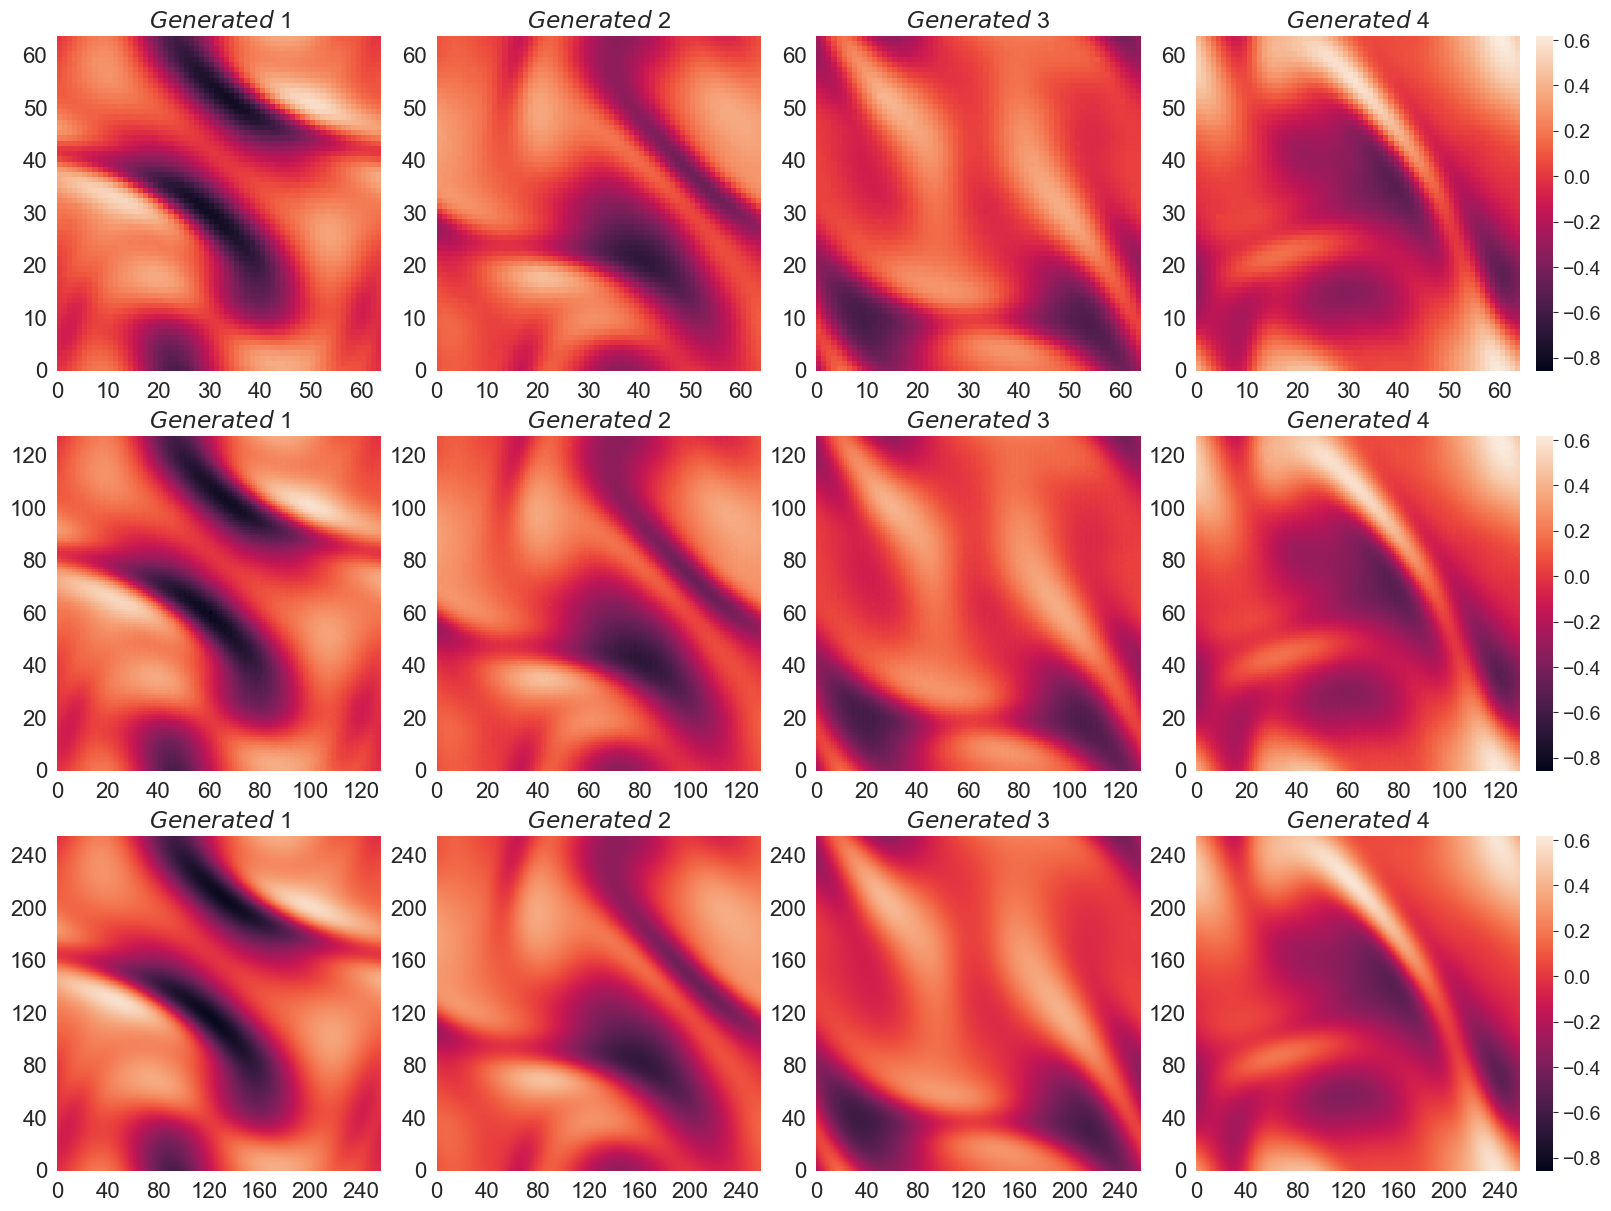

In [8]:
plot_heatmaps_sample(samples_64_interp, samples_128_interp, test_nonlinear_256)

### Convolution Model Sampling

In [9]:
samples_64_conv = sampler(test_vorticity_64[:sample_batch_size, :, :], test_nonlinear_64_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=64)
samples_128_conv = sampler(test_vorticity_128[:sample_batch_size, :, :], test_nonlinear_128_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=128)
samples_256_conv = sampler(test_vorticity_256[:sample_batch_size, :, :], test_nonlinear_256_sparse_normalized[:sample_batch_size, :, :], model_conv, spatial_dim=256)

#### Evaluations

In [10]:
### MSE and Relative Error
mse_64_conv = torch.mean((samples_64_conv - test_nonlinear_64[:sample_batch_size, :, :])**2)
rel_64_conv = torch.mean( torch.norm(samples_64_conv - test_nonlinear_64[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_64[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_128_conv = torch.mean((samples_128_conv - test_nonlinear_128[:sample_batch_size, :, :])**2)
rel_128_conv = torch.mean( torch.norm(samples_128_conv - test_nonlinear_128[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_128[:sample_batch_size, :, :], 2, dim=(1, 2)))

mse_256_conv = torch.mean((samples_256_conv - test_nonlinear_256[:sample_batch_size, :, :])**2)
rel_256_conv = torch.mean( torch.norm(samples_256_conv - test_nonlinear_256[:sample_batch_size, :, :], 2, dim=(1, 2))
                    / torch.norm(test_nonlinear_256[:sample_batch_size, :, :], 2, dim=(1, 2)))

print(f"MSE 64 Conv: {mse_64_conv:.8f}, Relative Error 64 Conv: {rel_64_conv:.4f}")
print(f"MSE 128 Conv: {mse_128_conv:.8f}, Relative Error 128 Conv: {rel_128_conv:.4f}")
print(f"MSE 256 Conv: {mse_256_conv:.8f}, Relative Error 256 Conv: {rel_256_conv:.4f}")

MSE 64 Conv: 0.00023283, Relative Error 64 Conv: 0.0544
MSE 128 Conv: 0.00038604, Relative Error 128 Conv: 0.0814
MSE 256 Conv: 0.00065813, Relative Error 256 Conv: 0.1074


Random seed set as 12


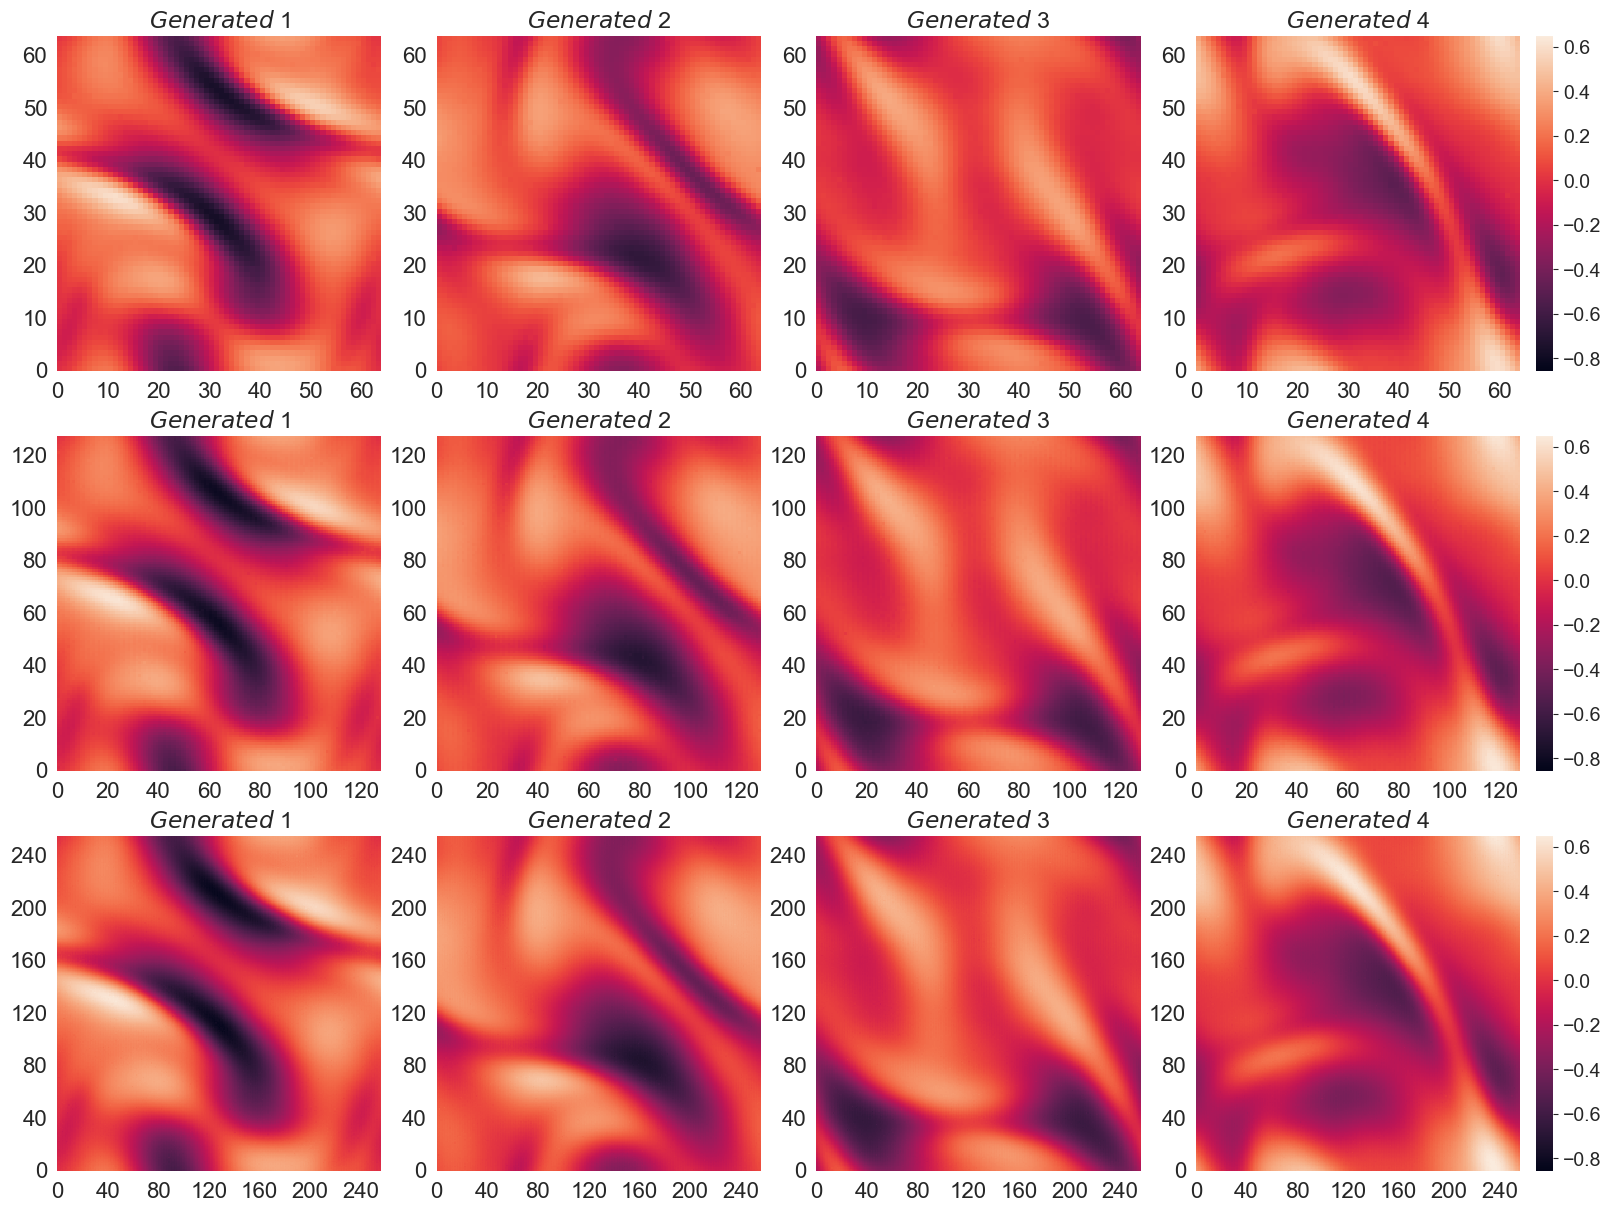

In [11]:
plot_heatmaps_sample(samples_64_conv, samples_128_conv, samples_256_conv)

### Energy Spectral

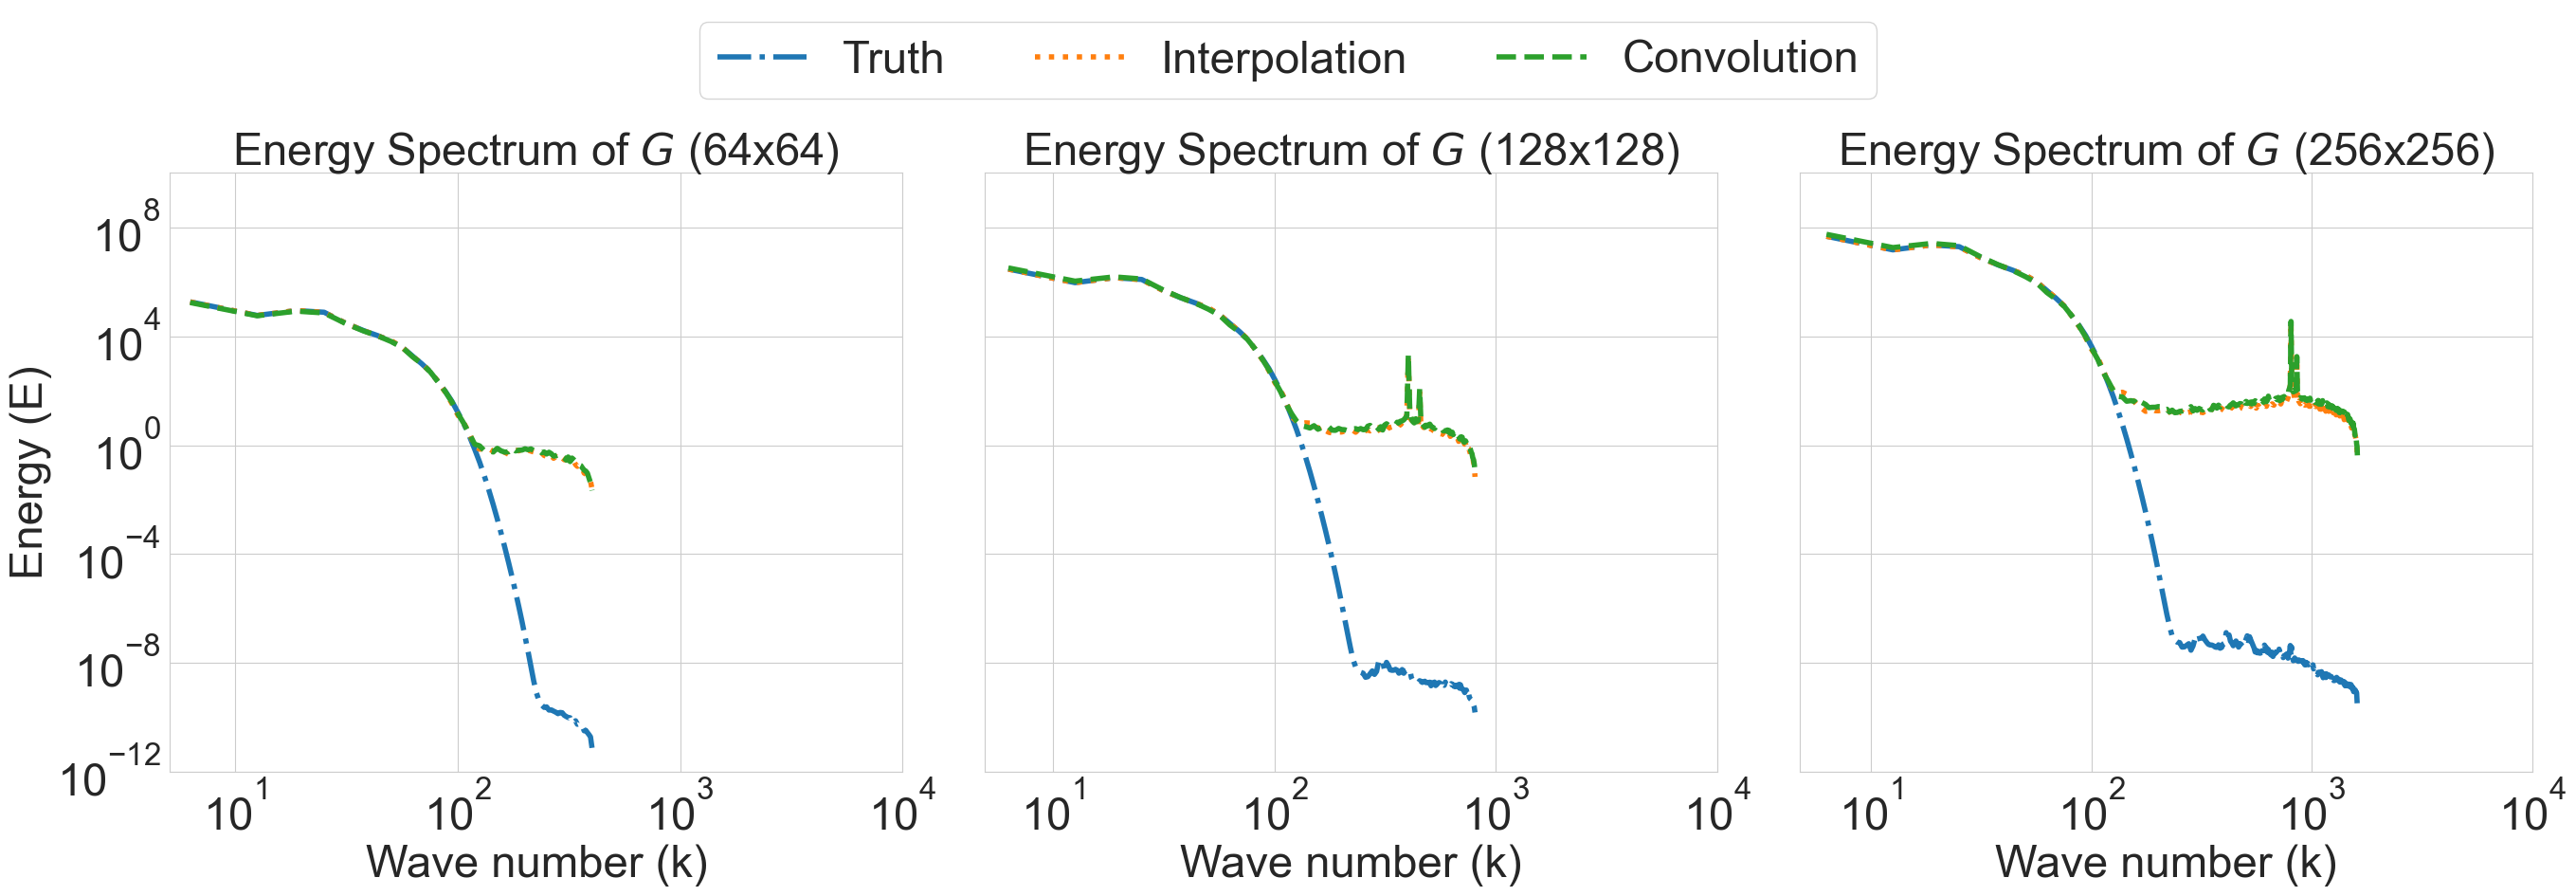

In [26]:
k64_conv, E64_conv = spectrum_2d(samples_64_conv.cpu(), 64, normalize=True)
k128_conv, E128_conv = spectrum_2d(samples_128_conv.cpu(), 128, normalize=True)
k256_conv, E256_conv = spectrum_2d(samples_256_conv.cpu(), 256, normalize=True)

k64_interp, E64_interp = spectrum_2d(samples_64_interp.cpu(), 64, normalize=True)
k128_interp, E128_interp = spectrum_2d(samples_128_interp.cpu(), 128, normalize=True)
k256_interp, E256_interp = spectrum_2d(samples_256_interp.cpu(), 256, normalize=True)

k_truth_64, E_truth_64 = spectrum_2d(test_nonlinear_64[:sample_batch_size, :, :].cpu(), 64, normalize=False)
k_truth_128, E_truth_128 = spectrum_2d(test_nonlinear_128[:sample_batch_size, :, :].cpu(), 128, normalize=False)
k_truth_256, E_truth_256 = spectrum_2d(test_nonlinear_256[:sample_batch_size, :, :].cpu(), 256, normalize=False)

resolutions = [64, 128, 256]
conv_kn = [k64_conv, k128_conv, k256_conv]
conv_E = [E64_conv, E128_conv, E256_conv]

interp_kn = [k64_interp, k128_interp, k256_interp]
interp_E = [E64_interp, E128_interp, E256_interp]

truth_kn = [k_truth_64, k_truth_128, k_truth_256]
truth_E = [E_truth_64, E_truth_128, E_truth_256]

fig, axs = plt.subplots(1, 3, figsize=(28, 10), sharey=True)
fs = 34
plt.rcParams.update({'font.size': fs})
plt.rcParams.update({'legend.fontsize': 35})  # Ensure the legend font size is updated


for i, res in enumerate(resolutions):
    # Upper row plots
    col = i
    axs[col].loglog(truth_kn[i], truth_E[i], label='Truth', linestyle='-.', linewidth=4)
    axs[col].loglog(interp_kn[i], interp_E[i], label='Interpolation', linestyle=':', linewidth=4)
    axs[col].loglog(conv_kn[i], conv_E[i], label='Convolution', linestyle='--', linewidth=4)

    axs[col].set_ylim(1e-18, 5 * 1e-1)
    axs[col].set_xlim(0, 1e3)
    axs[col].set_xscale('log')
    axs[col].set_yscale('log')
    axs[col].set_title(f'Energy Spectrum of $G$ ({res}x{res})', fontsize = fs)
    axs[col].set_xlabel('Wave number (k)', fontsize = fs)

axs[0].set_ylabel('Energy (E)', fontsize=fs)

for ax in axs.flat:
    ax.set_ylim(1e-12, 1e10)
    ax.set_xlim(0, 1e4)
    ax.set_xscale('log')
    ax.set_yscale('log')

# Create a shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fs)
# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust this value as needed
plt.show()

In [58]:
import numpy as np
import pyfftw
def energy_spectrum_t(nx,ny,w):
    epsilon = 1.0e-6

    dx = 2.0*np.pi/np.float64(nx)
    dy = 2.0*np.pi/np.float64(ny)

    kx = np.empty(nx)
    ky = np.empty(ny)

    kx[0:int(nx/2)] = 2*np.pi/(np.float64(nx)*dx)*np.float64(np.arange(0,int(nx/2)))
    kx[int(nx/2):nx] = 2*np.pi/(np.float64(nx)*dx)*np.float64(np.arange(-int(nx/2),0))

    ky[0:ny] = kx[0:ny]

    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(kx, ky, indexing='ij')

    a = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    b = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')

    fft_object = pyfftw.FFTW(a, b, axes = (0,1), direction = 'FFTW_FORWARD')
    wf = fft_object(w)

    es =  np.empty((nx,ny))

    kk = np.sqrt(kx[:,:]**2 + ky[:,:]**2)
    es[:,:] = np.pi*((np.abs(wf[:,:])/(nx*ny))**2)/kk

    n = int(np.sqrt(nx*nx + ny*ny)/2.0)-1

    en = np.zeros(n+1)

    for k in range(1,n+1):
        en[k] = 0.0
        ic = 0
        ii,jj = np.where((kk[1:,1:]>(k-0.5)) & (kk[1:,1:]<(k+0.5)))
        ic = ii.size
        ii = ii+1
        jj = jj+1
        en[k] = np.sum(es[ii,jj])
        en[k] = en[k]/ic
    kn = np.linspace(1, n, n) * 2 * np.pi
    return kn, en[1:]

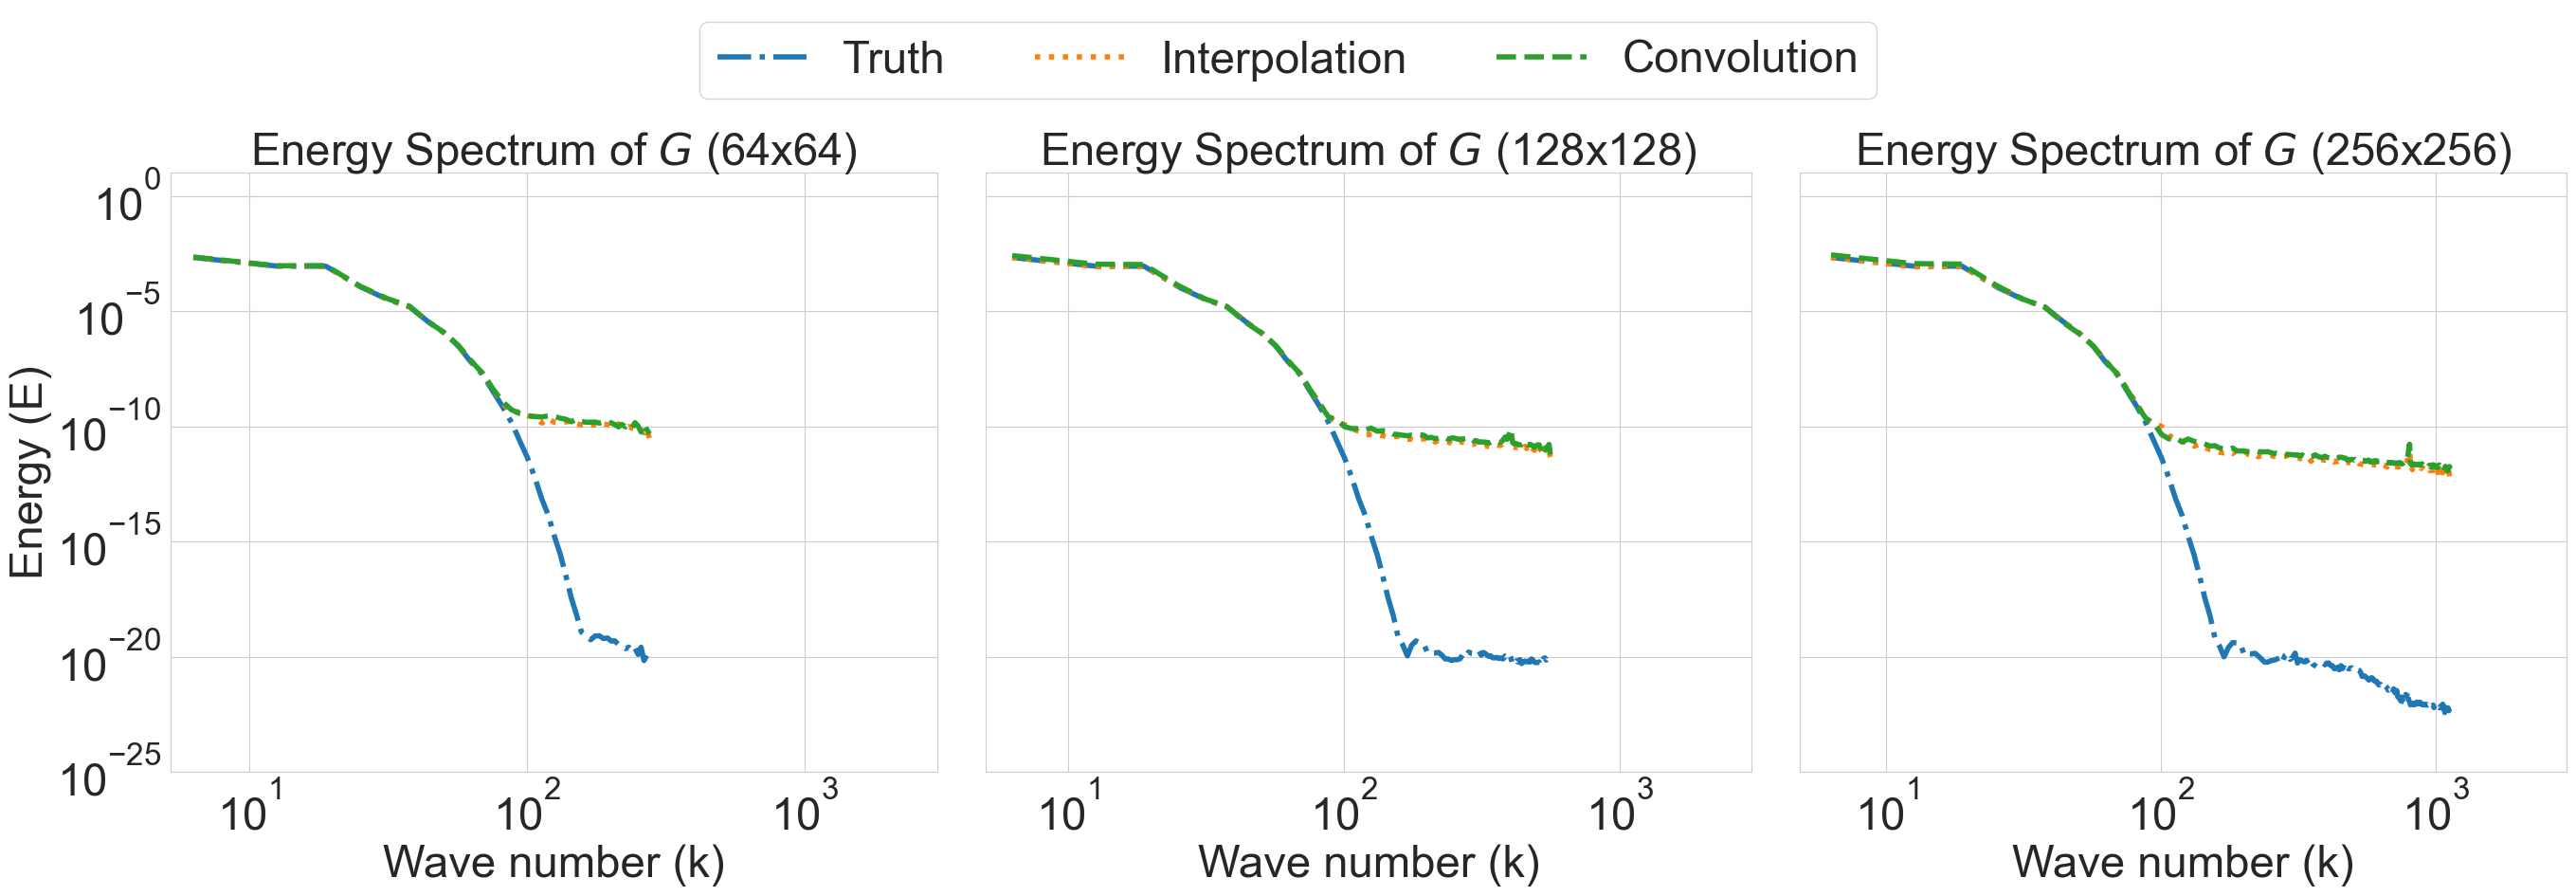

In [64]:
k64_conv, E64_conv = energy_spectrum_t(64, 64, samples_64_conv[0].cpu())
k128_conv, E128_conv = energy_spectrum_t(128, 128, samples_128_conv[0].cpu())
k256_conv, E256_conv = energy_spectrum_t(256, 256, samples_256_conv[0].cpu())

k64_interp, E64_interp = energy_spectrum_t(64, 64, samples_64_interp[0].cpu())
k128_interp, E128_interp = energy_spectrum_t(128, 128, samples_128_interp[0].cpu())
k256_interp, E256_interp = energy_spectrum_t(256, 256, samples_256_interp[0].cpu())

k64_truth, E64_truth = energy_spectrum_t(64, 64, test_nonlinear_64[0].cpu())
k128_truth, E128_truth = energy_spectrum_t(128, 128, test_nonlinear_128[0].cpu())
k256_truth, E256_truth = energy_spectrum_t(256, 256, test_nonlinear_256[0].cpu())

resolutions = [64, 128, 256]
conv_kn = [k64_conv, k128_conv, k256_conv]
conv_E = [E64_conv, E128_conv, E256_conv]

interp_kn = [k64_interp, k128_interp, k256_interp]
interp_E = [E64_interp, E128_interp, E256_interp]

truth_kn = [k64_truth, k128_truth, k256_truth]
truth_E = [E64_truth, E128_truth, E256_truth]

fig, axs = plt.subplots(1, 3, figsize=(28, 10), sharey=True)
fs = 34
plt.rcParams.update({'font.size': fs})
plt.rcParams.update({'legend.fontsize': 35})  # Ensure the legend font size is updated


for i, res in enumerate(resolutions):
    # Upper row plots
    col = i
    axs[col].loglog(truth_kn[i], truth_E[i], label='Truth', linestyle='-.', linewidth=4)
    axs[col].loglog(interp_kn[i], interp_E[i], label='Interpolation', linestyle=':', linewidth=4)
    axs[col].loglog(conv_kn[i], conv_E[i], label='Convolution', linestyle='--', linewidth=4)

    axs[col].set_ylim(1e-18, 5 * 1e-1)
    axs[col].set_xlim(0, 1e3)
    axs[col].set_xscale('log')
    axs[col].set_yscale('log')
    axs[col].set_title(f'Energy Spectrum of $G$ ({res}x{res})', fontsize = fs)
    axs[col].set_xlabel('Wave number (k)', fontsize = fs)

axs[0].set_ylabel('Energy (E)', fontsize=fs)

for ax in axs.flat:
    ax.set_ylim(1e-25, 1e1)
    ax.set_xlim(0, 3 * 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')

# Create a shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fs)
# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust this value as needed
plt.show()


In [47]:
k64_truth

array([  6.28318531,  11.79700098,  17.31081666,  22.82463234,
        28.33844802,  33.8522637 ,  39.36607937,  44.87989505,
        50.39371073,  55.90752641,  61.42134208,  66.93515776,
        72.44897344,  77.96278912,  83.4766048 ,  88.99042047,
        94.50423615, 100.01805183, 105.53186751, 111.04568318,
       116.55949886, 122.07331454, 127.58713022, 133.10094589,
       138.61476157, 144.12857725, 149.64239293, 155.15620861,
       160.67002428, 166.18383996, 171.69765564, 177.21147132,
       182.72528699, 188.23910267, 193.75291835, 199.26673403,
       204.78054971, 210.29436538, 215.80818106, 221.32199674,
       226.83581242, 232.34962809, 237.86344377, 243.37725945,
       248.89107513, 254.4048908 , 259.91870648, 265.43252216,
       270.94633784, 276.46015352])

In [63]:
E256_truth

array([2.11969253e-03, 9.00331409e-04, 8.89729270e-04, 1.13156952e-04,
       3.22251434e-05, 1.54929569e-05, 3.52021253e-06, 1.14751868e-06,
       3.07892436e-07, 6.11019991e-08, 1.81326835e-08, 3.29382457e-09,
       7.17077637e-10, 1.46231174e-10, 2.28501541e-11, 4.15003271e-12,
       5.81080281e-13, 6.98933687e-14, 1.36326582e-14, 1.63290502e-15,
       2.66887403e-16, 3.11944008e-17, 3.45565175e-18, 6.14272018e-19,
       6.82219256e-20, 2.92683066e-20, 9.88490340e-21, 2.46934727e-20,
       4.09205040e-20, 3.98938202e-20, 3.61355695e-20, 1.15966301e-20,
       1.36052265e-20, 1.31753746e-20, 1.41419526e-20, 1.06547770e-20,
       7.86080106e-21, 5.77912231e-21, 5.83229381e-21, 6.71142182e-21,
       7.04765039e-21, 7.81113471e-21, 8.99666747e-21, 5.72830129e-21,
       1.13197716e-20, 1.34928556e-20, 7.67555680e-21, 9.29080751e-21,
       1.43420755e-20, 5.30277388e-21, 7.35886559e-21, 6.65476049e-21,
       5.91119667e-21, 6.97790254e-21, 4.55723175e-21, 6.48405425e-21,
      